In [1]:
# ============================================================================
# Aureus Sigma Capital - Production Strategy Backtest (v1.1)
# Notebook: 09_production_strategy_backtest.ipynb
#
# Description:
# This notebook implements and validates the final, production-ready "v1.1"
# strategies. It uses an upgraded backtesting engine that incorporates
# critical, data-driven operational enhancements:
#   1. ADTV-based liquidity filtering (10B VND threshold).
#   2. Fixed-number stock selection (25 stocks) for portfolio stability.
#   3. Explicit position weight caps (8%).
#
# This notebook serves as the canonical source for the final performance
# metrics of our official product suite.
#
# Author: Duc Nguyen, Quantitative Finance Expert
# Date: July 28, 2025
# Version: 1.1 - Production-Ready Engine
# ============================================================================

# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
import warnings
from typing import Dict, List, Tuple, Optional
from pathlib import Path
import yaml
from sqlalchemy import create_engine, text
from tqdm import tqdm

warnings.filterwarnings('ignore')

# --- INSTITUTIONAL PALETTE ---
STRATEGY_COLORS = {
    'Benchmark': '#34495E',
    'Aggressive Growth v1.1': '#E74C3C',
    'Balanced Growth v1.1': '#F39C12',
    'Risk-Managed Institutional v1.1': '#16A085',
    'Positive': '#27AE60', 'Negative': '#C0392B', 'Drawdown': '#E67E22',
    'Grid': '#BDC3C7', 'Text_Primary': '#2C3E50'
}

# --- VISUALIZATION CONFIGURATION ---
plt.style.use('default')
plt.rcParams.update({
    'figure.dpi': 300, 'savefig.dpi': 300, 'figure.figsize': (15, 8),
    'figure.facecolor': 'white', 'font.size': 11,
    'axes.facecolor': 'white', 'axes.edgecolor': STRATEGY_COLORS['Text_Primary'],
    'axes.linewidth': 1.0, 'axes.grid': True, 'axes.axisbelow': True,
    'axes.labelcolor': STRATEGY_COLORS['Text_Primary'], 'axes.titlesize': 14,
    'axes.titleweight': 'bold', 'axes.titlecolor': STRATEGY_COLORS['Text_Primary'],
    'grid.color': STRATEGY_COLORS['Grid'], 'grid.alpha': 0.3, 'grid.linewidth': 0.5,
    'legend.frameon': False, 'legend.fontsize': 10,
    'xtick.color': STRATEGY_COLORS['Text_Primary'], 'ytick.color': STRATEGY_COLORS['Text_Primary'],
    'xtick.labelsize': 10, 'ytick.labelsize': 10,
    'lines.linewidth': 2.0, 'lines.solid_capstyle': 'round'
})

print("📊 Visualization environment configured.")

# --- v1.1 PRODUCTION STRATEGY CONFIGURATION ---
# This configuration is the final output of all our research and analysis.
PRODUCTION_CONFIG = {
    "rebalance_freq": 'Q',
    "liquidity_threshold_vnd": 10_000_000_000, # 10B VND (Validated in Notebook 10)
    "adtv_lookback_days": 63, # 3 months
    "selection_method": 'fixed_number',
    "portfolio_size": 25,
    "weighting_method": 'equal',
    "max_sector_weight": 0.40,
    "max_position_weight": 0.08, # 8% cap
    "transaction_cost_bps": 30
}

# --- ANALYSIS PERIOD ---
ANALYSIS_START_DATE = "2018-01-01"
ANALYSIS_END_DATE = "2025-07-25"

print("\n" + "=" * 70)
print("🏆 Aureus Sigma: Production Strategy Backtest (v1.1)")
print("=" * 70)
print("\n🔬 Production Configuration:")
for key, value in PRODUCTION_CONFIG.items():
    if "vnd" in key:
        print(f"   - {key:<25}: {value:,.0f} VND")
    else:
        print(f"   - {key:<25}: {value}")
print("-" * 70)

📊 Visualization environment configured.

🏆 Aureus Sigma: Production Strategy Backtest (v1.1)

🔬 Production Configuration:
   - rebalance_freq           : Q
   - liquidity_threshold_vnd  : 10,000,000,000 VND
   - adtv_lookback_days       : 63
   - selection_method         : fixed_number
   - portfolio_size           : 25
   - weighting_method         : equal
   - max_sector_weight        : 0.4
   - max_position_weight      : 0.08
   - transaction_cost_bps     : 30
----------------------------------------------------------------------


In [3]:
# ============================================================================
# CELL 2: THE PRODUCTION-READY BACKTESTING ENGINE (v1.1)
# ============================================================================

print("🔧 Defining the production-ready backtesting engine (v1.1)...")

# --- Helper Function: Portfolio Construction (v1.1) ---
def construct_constrained_portfolio_v1_1(
    factor_scores: pd.Series, 
    sector_info: pd.DataFrame, 
    config: dict
) -> pd.DataFrame:
    """
    Constructs a portfolio with liquidity, fixed-number, and constraint logic.
    """
    if factor_scores.empty: return pd.DataFrame()

    # --- Step 1: Stock Selection (Fixed Number) ---
    selected_stocks_df = factor_scores.nlargest(config['portfolio_size']).to_frame('factor_score')
    
    portfolio_df = selected_stocks_df.join(sector_info).dropna(subset=['sector'])
    if portfolio_df.empty: return pd.DataFrame()

    # --- Step 2: Sector Constraint Application ---
    sector_counts = portfolio_df['sector'].value_counts()
    # Note: max_stocks_per_sector is now based on the fixed portfolio size
    max_stocks_per_sector = int(config['portfolio_size'] * config['max_sector_weight'])
    final_tickers = set()
    for sector, count in sector_counts.items():
        sector_stocks = portfolio_df[portfolio_df['sector'] == sector]
        if count > max_stocks_per_sector > 0:
            final_tickers.update(sector_stocks.nlargest(max_stocks_per_sector, 'factor_score').index)
        else:
            final_tickers.update(sector_stocks.index)
    
    final_portfolio = portfolio_df.loc[list(final_tickers)].copy()
    if final_portfolio.empty: return pd.DataFrame()

    # --- Step 3: Weighting ---
    if config['weighting_method'] == 'equal':
        final_portfolio['weight'] = 1.0 / len(final_portfolio)
    
    final_portfolio['weight'] = final_portfolio['weight'].clip(upper=config['max_position_weight'])
    final_portfolio['weight'] /= final_portfolio['weight'].sum()
    
    return final_portfolio

# --- Master Backtesting Function (v1.1) ---
def run_detailed_backtest_v1_1(
    strategy_name: str,
    risk_factor: float,
    base_config: dict,
    factor_data: dict,
    daily_returns: pd.DataFrame,
    sector_info: pd.DataFrame,
    market_regimes: pd.DataFrame,
    adtv_data: pd.DataFrame
) -> Dict:
    """
    Runs a full backtest for a hybrid strategy using the production-ready v1.1 logic.
    """
    print(f"\n--- Running v1.1 backtest for: {strategy_name} (Risk Factor: {risk_factor}) ---")
    
    config = base_config.copy()
    
    # --- Prepare "As-Of" Data ---
    rebalance_dates = pd.date_range(start=daily_returns.index.min(), end=daily_returns.index.max(), freq=config['rebalance_freq'])
    regimes_on_rebal_dates = market_regimes.reindex(rebalance_dates, method='ffill')
    q_scores_on_rebal_dates = factor_data['quality'].reindex(rebalance_dates, method='ffill')
    v_scores_on_rebal_dates = factor_data['value'].reindex(rebalance_dates, method='ffill')
    m_scores_on_rebal_dates = factor_data['momentum'].reindex(rebalance_dates, method='ffill')
    adtv_on_rebal_dates = adtv_data.reindex(rebalance_dates, method='ffill')
    print("   - 'As-of' lookup tables created.")

    # --- Portfolio Construction Loop ---
    portfolios = {}
    universe_size_log = {}
    for date in tqdm(rebalance_dates, desc=f"Constructing Portfolios for {strategy_name}"):
        regime = regimes_on_rebal_dates.loc[date, 'regime']
        
        # Dynamic Alpha Calculation
        if regime == 'Stress':
            qvm_composite = (0.35 * q_scores_on_rebal_dates.loc[date]) + (0.35 * v_scores_on_rebal_dates.loc[date]) - (0.30 * m_scores_on_rebal_dates.loc[date])
        else:
            qvm_composite = (0.50 * q_scores_on_rebal_dates.loc[date]) + (0.50 * v_scores_on_rebal_dates.loc[date])
        
        # Liquidity Filtering
        current_adtv = adtv_on_rebal_dates.loc[date]
        liquid_universe_mask = current_adtv >= config['liquidity_threshold_vnd']
        liquid_qvm_scores = qvm_composite[liquid_universe_mask]
        universe_size_log[date] = len(liquid_qvm_scores.dropna())
        
        portfolio_df = construct_constrained_portfolio_v1_1(liquid_qvm_scores.dropna(), sector_info, config)
        if not portfolio_df.empty:
            portfolio_df = portfolio_df.join(q_scores_on_rebal_dates.loc[date].rename('quality_score'))
            portfolio_df = portfolio_df.join(v_scores_on_rebal_dates.loc[date].rename('value_score'))
            portfolio_df = portfolio_df.join(m_scores_on_rebal_dates.loc[date].rename('momentum_score'))
            portfolios[date] = portfolio_df

    # --- Generate Daily Holdings & Apply Risk Overlay ---
    alpha_holdings = pd.DataFrame(index=daily_returns.index, columns=daily_returns.columns).fillna(0.0)
    for i, date in enumerate(rebalance_dates):
        if date in portfolios:
            next_date = rebalance_dates[i+1] if i + 1 < len(rebalance_dates) else daily_returns.index[-1] + pd.Timedelta(days=1)
            holding_period = daily_returns.index[(daily_returns.index > date) & (daily_returns.index < next_date)]
            portfolio = portfolios[date]
            for day in holding_period:
                alpha_holdings.loc[day, portfolio.index] = portfolio['weight']
    
    exposure_signal = pd.Series(1.0, index=market_regimes.index)
    risk_mask = market_regimes['regime'].isin(['Bear', 'Stress'])
    exposure_signal.loc[market_regimes[risk_mask].index] = risk_factor
    hybrid_holdings = alpha_holdings.mul(exposure_signal, axis=0)
    
    # --- Calculate Net Returns ---
    holdings_shifted = hybrid_holdings.shift(1).fillna(0)
    gross_returns = (holdings_shifted * daily_returns).sum(axis=1)
    turnover = (holdings_shifted - holdings_shifted.shift(1)).abs().sum(axis=1) / 2
    transaction_costs = turnover * (config['transaction_cost_bps'] / 10000)
    net_returns = gross_returns - transaction_costs
    
    print(f"   - Backtest complete. Average liquid universe size: {np.mean(list(universe_size_log.values())):.0f} stocks.")
    
    return {
        'name': strategy_name,
        'returns': net_returns,
        'portfolios': portfolios,
        'universe_log': universe_size_log
    }

print("✅ Production-ready backtesting engine `run_detailed_backtest_v1_1` is defined.")

🔧 Defining the production-ready backtesting engine (v1.1)...
✅ Production-ready backtesting engine `run_detailed_backtest_v1_1` is defined.


In [4]:
# ============================================================================
# CELL 3: LOAD ALL REQUIRED DATA FOR v1.1 BACKTEST
# ============================================================================

print("📂 Loading all data sources required for the v1.1 backtesting engine...")

# --- Establish Paths and Database Connection ---
project_root = Path.cwd()
while not (project_root / 'config').exists():
    if project_root.parent == project_root:
        raise FileNotFoundError("Could not find project root directory.")
    project_root = project_root.parent

phase7_path = project_root / "production" / "tests" / "phase7_institutional_backtesting"
phase8_path = project_root / "production" / "tests" / "phase8_risk_management"

config_path = project_root / 'config' / 'database.yml'
with open(config_path, 'r') as f:
    db_config = yaml.safe_load(f)['production']
engine = create_engine(
    f"mysql+pymysql://{db_config['username']}:{db_config['password']}@"
    f"{db_config['host']}/{db_config['schema_name']}",
    pool_pre_ping=True
)

# --- 1. Load Factor Scores ---
with open(phase7_path / "factor_data.pkl", "rb") as f:
    factor_data_obj = pickle.load(f)
factor_data_full = factor_data_obj['data']
factor_scores_dict = {
    'quality': factor_data_full['quality_score'],
    'value': factor_data_full['value_score'],
    'momentum': factor_data_full['momentum_score']
}
print("   - ✅ Factor Scores loaded.")

# --- 2. Load Daily Returns ---
with open(phase7_path / "daily_returns.pkl", "rb") as f:
    returns_data_obj = pickle.load(f)
daily_returns_full = returns_data_obj['data']
print("   - ✅ Daily Returns loaded.")

# --- 3. Load Sector Info ---
sector_info_sql = "SELECT ticker, sector FROM master_info WHERE sector IS NOT NULL"
sector_info = pd.read_sql(sector_info_sql, engine).drop_duplicates(subset=['ticker']).set_index('ticker')
print(f"   - ✅ Sector Info loaded for {len(sector_info)} tickers.")

# --- 4. Load Market Regimes ---
with open(phase8_path / "phase8_results.pkl", "rb") as f:
    phase8_results = pickle.load(f)
market_regimes_full = phase8_results['market_regimes']
print("   - ✅ Market Regimes loaded.")

# --- 5. Load and Calculate ADTV Data ---
print("   - Loading raw market data to calculate ADTV...")
# This query is optimized to only fetch the columns we need
adtv_query = text("""
    SELECT trading_date AS date, ticker, close_price_adjusted AS close, total_volume AS volume
    FROM vcsc_daily_data_complete
    WHERE trading_date BETWEEN '2017-09-01' AND :end_date; -- Fetch extra data for lookback
""")
raw_market_data = pd.read_sql(adtv_query, engine, params={'end_date': ANALYSIS_END_DATE}, parse_dates=['date'])
engine.dispose()
print("   - Raw market data loaded. Calculating 3-Month ADTV...")

# Calculate daily turnover in VND
raw_market_data['turnover_vnd'] = raw_market_data['close'] * raw_market_data['volume']

# Pivot to have tickers as columns
turnover_pivot = raw_market_data.pivot(index='date', columns='ticker', values='turnover_vnd')

# Calculate 3-month (63-day) rolling average
adtv_lookback = PRODUCTION_CONFIG['adtv_lookback_days']
adtv_data = turnover_pivot.rolling(window=adtv_lookback, min_periods=int(adtv_lookback * 0.8)).mean()
print(f"   - ✅ {adtv_lookback}-day rolling ADTV calculated.")

print("\n" + "=" * 80)
print("✅ All data sources are loaded and prepared. Ready to run v1.1 backtests.")
print("=" * 80)

📂 Loading all data sources required for the v1.1 backtesting engine...
   - ✅ Factor Scores loaded.
   - ✅ Daily Returns loaded.
   - ✅ Sector Info loaded for 728 tickers.
   - ✅ Market Regimes loaded.
   - Loading raw market data to calculate ADTV...
   - Raw market data loaded. Calculating 3-Month ADTV...
   - ✅ 63-day rolling ADTV calculated.

✅ All data sources are loaded and prepared. Ready to run v1.1 backtests.


In [8]:
# ============================================================================
# CELL 3.5 (New): DEBUGGING BIOPSY FOR A SINGLE REBALANCING DATE
# ============================================================================

print("🔬 Conducting a debugging biopsy on the v1.1 portfolio construction process...")

# --- Select a Sample Rebalancing Date for Inspection ---
# Let's pick a date in a "normal" market period to see what's happening.
debug_date = pd.to_datetime("2021-03-31")
print(f"\n--- INSPECTING REBALANCING DATE: {debug_date.date()} ---")

# --- 1. Get the "As-Of" Data for this Date ---
q_scores_asof = factor_scores_dict['quality'].reindex([debug_date], method='ffill').iloc[0]
v_scores_asof = factor_scores_dict['value'].reindex([debug_date], method='ffill').iloc[0]
m_scores_asof = factor_scores_dict['momentum'].reindex([debug_date], method='ffill').iloc[0]
adtv_asof = adtv_data.reindex([debug_date], method='ffill').iloc[0]
regime_asof = market_regimes_full.reindex([debug_date], method='ffill').iloc[0]['regime']

print(f"   Market Regime on this date: '{regime_asof}'")

# --- 2. Calculate the QVM Composite Score (Pre-Filter) ---
if regime_asof == 'Stress':
    qvm_composite_full = (0.35 * q_scores_asof) + (0.35 * v_scores_asof) - (0.30 * m_scores_asof)
else:
    qvm_composite_full = (0.50 * q_scores_asof) + (0.50 * v_scores_asof)
qvm_composite_full = qvm_composite_full.dropna().sort_values(ascending=False)

print(f"\n--- PRE-FILTER ANALYSIS ---")
print(f"   Total stocks with a QVM score: {len(qvm_composite_full)}")
print("   Top 10 Stocks (Universe BEFORE Liquidity Filter):")
display(qvm_composite_full.head(10).to_frame('QVM Score'))

# --- 3. Apply the Liquidity Filter ---
liquidity_threshold = PRODUCTION_CONFIG['liquidity_threshold_vnd']
liquid_universe_mask = adtv_asof >= liquidity_threshold
liquid_qvm_scores = qvm_composite_full[liquid_universe_mask]

print(f"\n--- LIQUIDITY FILTER ANALYSIS (Threshold: {liquidity_threshold:,.0f} VND) ---")
print(f"   Stocks with ADTV data: {adtv_asof.notna().sum()}")
print(f"   Stocks passing liquidity filter: {liquid_universe_mask.sum()}")
print(f"   Resulting liquid universe size: {len(liquid_qvm_scores)}")

# --- 4. Analyze the Post-Filter Universe ---
print("\n--- POST-FILTER ANALYSIS ---")
if not liquid_qvm_scores.empty:
    liquid_qvm_scores = liquid_qvm_scores.sort_values(ascending=False)
    print("   Top 10 Stocks (Universe AFTER Liquidity Filter):")
    display(liquid_qvm_scores.head(10).to_frame('QVM Score'))

    # *** THE CRITICAL TEST ***
    # Let's see if the top stocks from the pre-filter universe survived.
    top_10_pre_filter_tickers = qvm_composite_full.head(10).index
    survival_mask = top_10_pre_filter_tickers.isin(liquid_qvm_scores.index)
    
    print("\n   *** SURVIVAL ANALYSIS of Top 10 Pre-Filter Stocks ***")
    survival_df = pd.DataFrame({
        'Ticker': top_10_pre_filter_tickers,
        'Survived Filter?': survival_mask
    })
    display(survival_df)
    
    if not survival_mask.all():
        print("\n   🚨 CRITICAL FINDING: High-scoring stocks are being REMOVED by the liquidity filter!")
        print("      This is the likely cause of the performance collapse.")
        
        # Show the ADTV of the stocks that failed
        failed_tickers = top_10_pre_filter_tickers[~survival_mask]
        print("\n      ADTV of Top-Scoring Stocks that FAILED the filter:")
        display(adtv_asof.loc[failed_tickers].to_frame('ADTV (VND)'))

else:
    print("   🚨 CATASTROPHIC FAILURE: The liquid universe is EMPTY. No stocks passed the filter.")

🔬 Conducting a debugging biopsy on the v1.1 portfolio construction process...

--- INSPECTING REBALANCING DATE: 2021-03-31 ---
   Market Regime on this date: 'Stress'

--- PRE-FILTER ANALYSIS ---
   Total stocks with a QVM score: 690
   Top 10 Stocks (Universe BEFORE Liquidity Filter):


,QVM Score
ticker,
TDH,1.328594
VMD,1.242832
TMB,1.237711
BLF,1.209131
V21,1.204598
LCD,1.038820
L43,0.997153
PMB,0.981441
MHL,0.954339



--- LIQUIDITY FILTER ANALYSIS (Threshold: 10,000,000,000 VND) ---
   Stocks with ADTV data: 707
   Stocks passing liquidity filter: 148
   Resulting liquid universe size: 145

--- POST-FILTER ANALYSIS ---
   Top 10 Stocks (Universe AFTER Liquidity Filter):


,QVM Score
ticker,
TDH,1.328594
VNM,0.552753
TCH,0.526475
AMV,0.521821
PHR,0.514583
VCS,0.500724
HQC,0.472343
LDG,0.452863
SAB,0.350398



   *** SURVIVAL ANALYSIS of Top 10 Pre-Filter Stocks ***


,Ticker,Survived Filter?
0,TDH,True
1,VMD,False
2,TMB,False
3,BLF,False
4,V21,False
5,LCD,False
6,L43,False
7,PMB,False
8,MHL,False
9,HU1,False



   🚨 CRITICAL FINDING: High-scoring stocks are being REMOVED by the liquidity filter!
      This is the likely cause of the performance collapse.

      ADTV of Top-Scoring Stocks that FAILED the filter:


,ADTV (VND)
ticker,
VMD,6.385293e+07
TMB,5.338379e+07
BLF,1.130644e+07
V21,4.846774e+07
LCD,1.079365e+02
L43,7.091811e+07
PMB,1.699720e+08
MHL,9.114610e+06
HU1,6.913849e+07


In [5]:
# ============================================================================
# CELL 4: EXECUTE v1.1 BACKTESTS AND GENERATE MASTER DATA
# ============================================================================

print("🚀 Executing production-ready v1.1 backtests for the entire product suite...")

# --- Product Suite Definitions ---
# We define the strategies by their name and key risk parameter
product_suite_definitions_v1_1 = {
    "Aggressive Growth v1.1": 0.5,
    "Balanced Growth v1.1": 0.3,
    "Risk-Managed Institutional v1.1": 0.2
}

# --- Run Backtests and Compile Master Data Object ---
master_analysis_data_v1_1 = {}

for name, risk_factor in product_suite_definitions_v1_1.items():
    strategy_results = run_detailed_backtest_v1_1(
        strategy_name=name,
        risk_factor=risk_factor,
        base_config=PRODUCTION_CONFIG,
        factor_data=factor_scores_dict,
        daily_returns=daily_returns_full,
        sector_info=sector_info,
        market_regimes=market_regimes_full,
        adtv_data=adtv_data
    )
    master_analysis_data_v1_1[name] = strategy_results

# --- Add the Benchmark for Comparison ---
with open(phase7_path / "benchmark_returns.pkl", "rb") as f:
    benchmark_data_obj = pickle.load(f)
benchmark_returns_full = benchmark_data_obj['data']

master_analysis_data_v1_1['Benchmark'] = {
    'name': 'Benchmark',
    'returns': benchmark_returns_full,
    'portfolios': {},
    'universe_log': {}
}

print("\n" + "=" * 80)
print("✅ v1.1 Master analysis data object created successfully.")
print("   Contains detailed returns and portfolio compositions for:")
for name in master_analysis_data_v1_1.keys():
    print(f"     - {name}")
print("=" * 80)

# --- Final Step: Slice the generated data to our analysis period ---
print(f"\n🔪 Slicing v1.1 master data to the analysis period: {ANALYSIS_START_DATE} to {ANALYSIS_END_DATE}")

final_returns_data_v1_1 = {}
final_portfolios_data_v1_1 = {}

for name, data in master_analysis_data_v1_1.items():
    final_returns_data_v1_1[name] = data['returns'].loc[ANALYSIS_START_DATE:ANALYSIS_END_DATE]
    # Filter portfolios to only include those relevant to the sliced period
    final_portfolios_data_v1_1[name] = {
        date: portfolio for date, portfolio in data['portfolios'].items()
        if pd.to_datetime(ANALYSIS_START_DATE) <= date <= pd.to_datetime(ANALYSIS_END_DATE)
    }

# Create the final, analysis-ready DataFrame of returns
returns_df_v1_1 = pd.DataFrame(final_returns_data_v1_1)

print("\n✅ All v1.1 data is now generated, correctly mapped, and sliced.")
print("   Ready for final performance analysis.")
display(returns_df_v1_1.head())

🚀 Executing production-ready v1.1 backtests for the entire product suite...

--- Running v1.1 backtest for: Aggressive Growth v1.1 (Risk Factor: 0.5) ---
   - 'As-of' lookup tables created.


Constructing Portfolios for Aggressive Growth v1.1: 100%|██████████| 38/38 [00:00<00:00, 255.62it/s]


   - Backtest complete. Average liquid universe size: 103 stocks.

--- Running v1.1 backtest for: Balanced Growth v1.1 (Risk Factor: 0.3) ---
   - 'As-of' lookup tables created.


Constructing Portfolios for Balanced Growth v1.1: 100%|██████████| 38/38 [00:00<00:00, 319.22it/s]


   - Backtest complete. Average liquid universe size: 103 stocks.

--- Running v1.1 backtest for: Risk-Managed Institutional v1.1 (Risk Factor: 0.2) ---
   - 'As-of' lookup tables created.


Constructing Portfolios for Risk-Managed Institutional v1.1: 100%|██████████| 38/38 [00:00<00:00, 276.79it/s]


   - Backtest complete. Average liquid universe size: 103 stocks.

✅ v1.1 Master analysis data object created successfully.
   Contains detailed returns and portfolio compositions for:
     - Aggressive Growth v1.1
     - Balanced Growth v1.1
     - Risk-Managed Institutional v1.1
     - Benchmark

🔪 Slicing v1.1 master data to the analysis period: 2018-01-01 to 2025-07-25

✅ All v1.1 data is now generated, correctly mapped, and sliced.
   Ready for final performance analysis.


,Aggressive Growth v1.1,Balanced Growth v1.1,Risk-Managed Institutional v1.1,Benchmark
2018-01-02,0.000000,0.000000,0.000000,0.011715
2018-01-03,0.008914,0.008914,0.008914,0.009942
2018-01-04,0.016222,0.016222,0.016222,0.014001
2018-01-05,-0.006145,-0.006145,-0.006145,-0.006962
2018-01-08,0.010252,0.010252,0.010252,0.010122


📊 Generating final performance analysis for the v1.1 Production Strategies...
   - Performance analysis re-based to true inception date: 2018-01-03


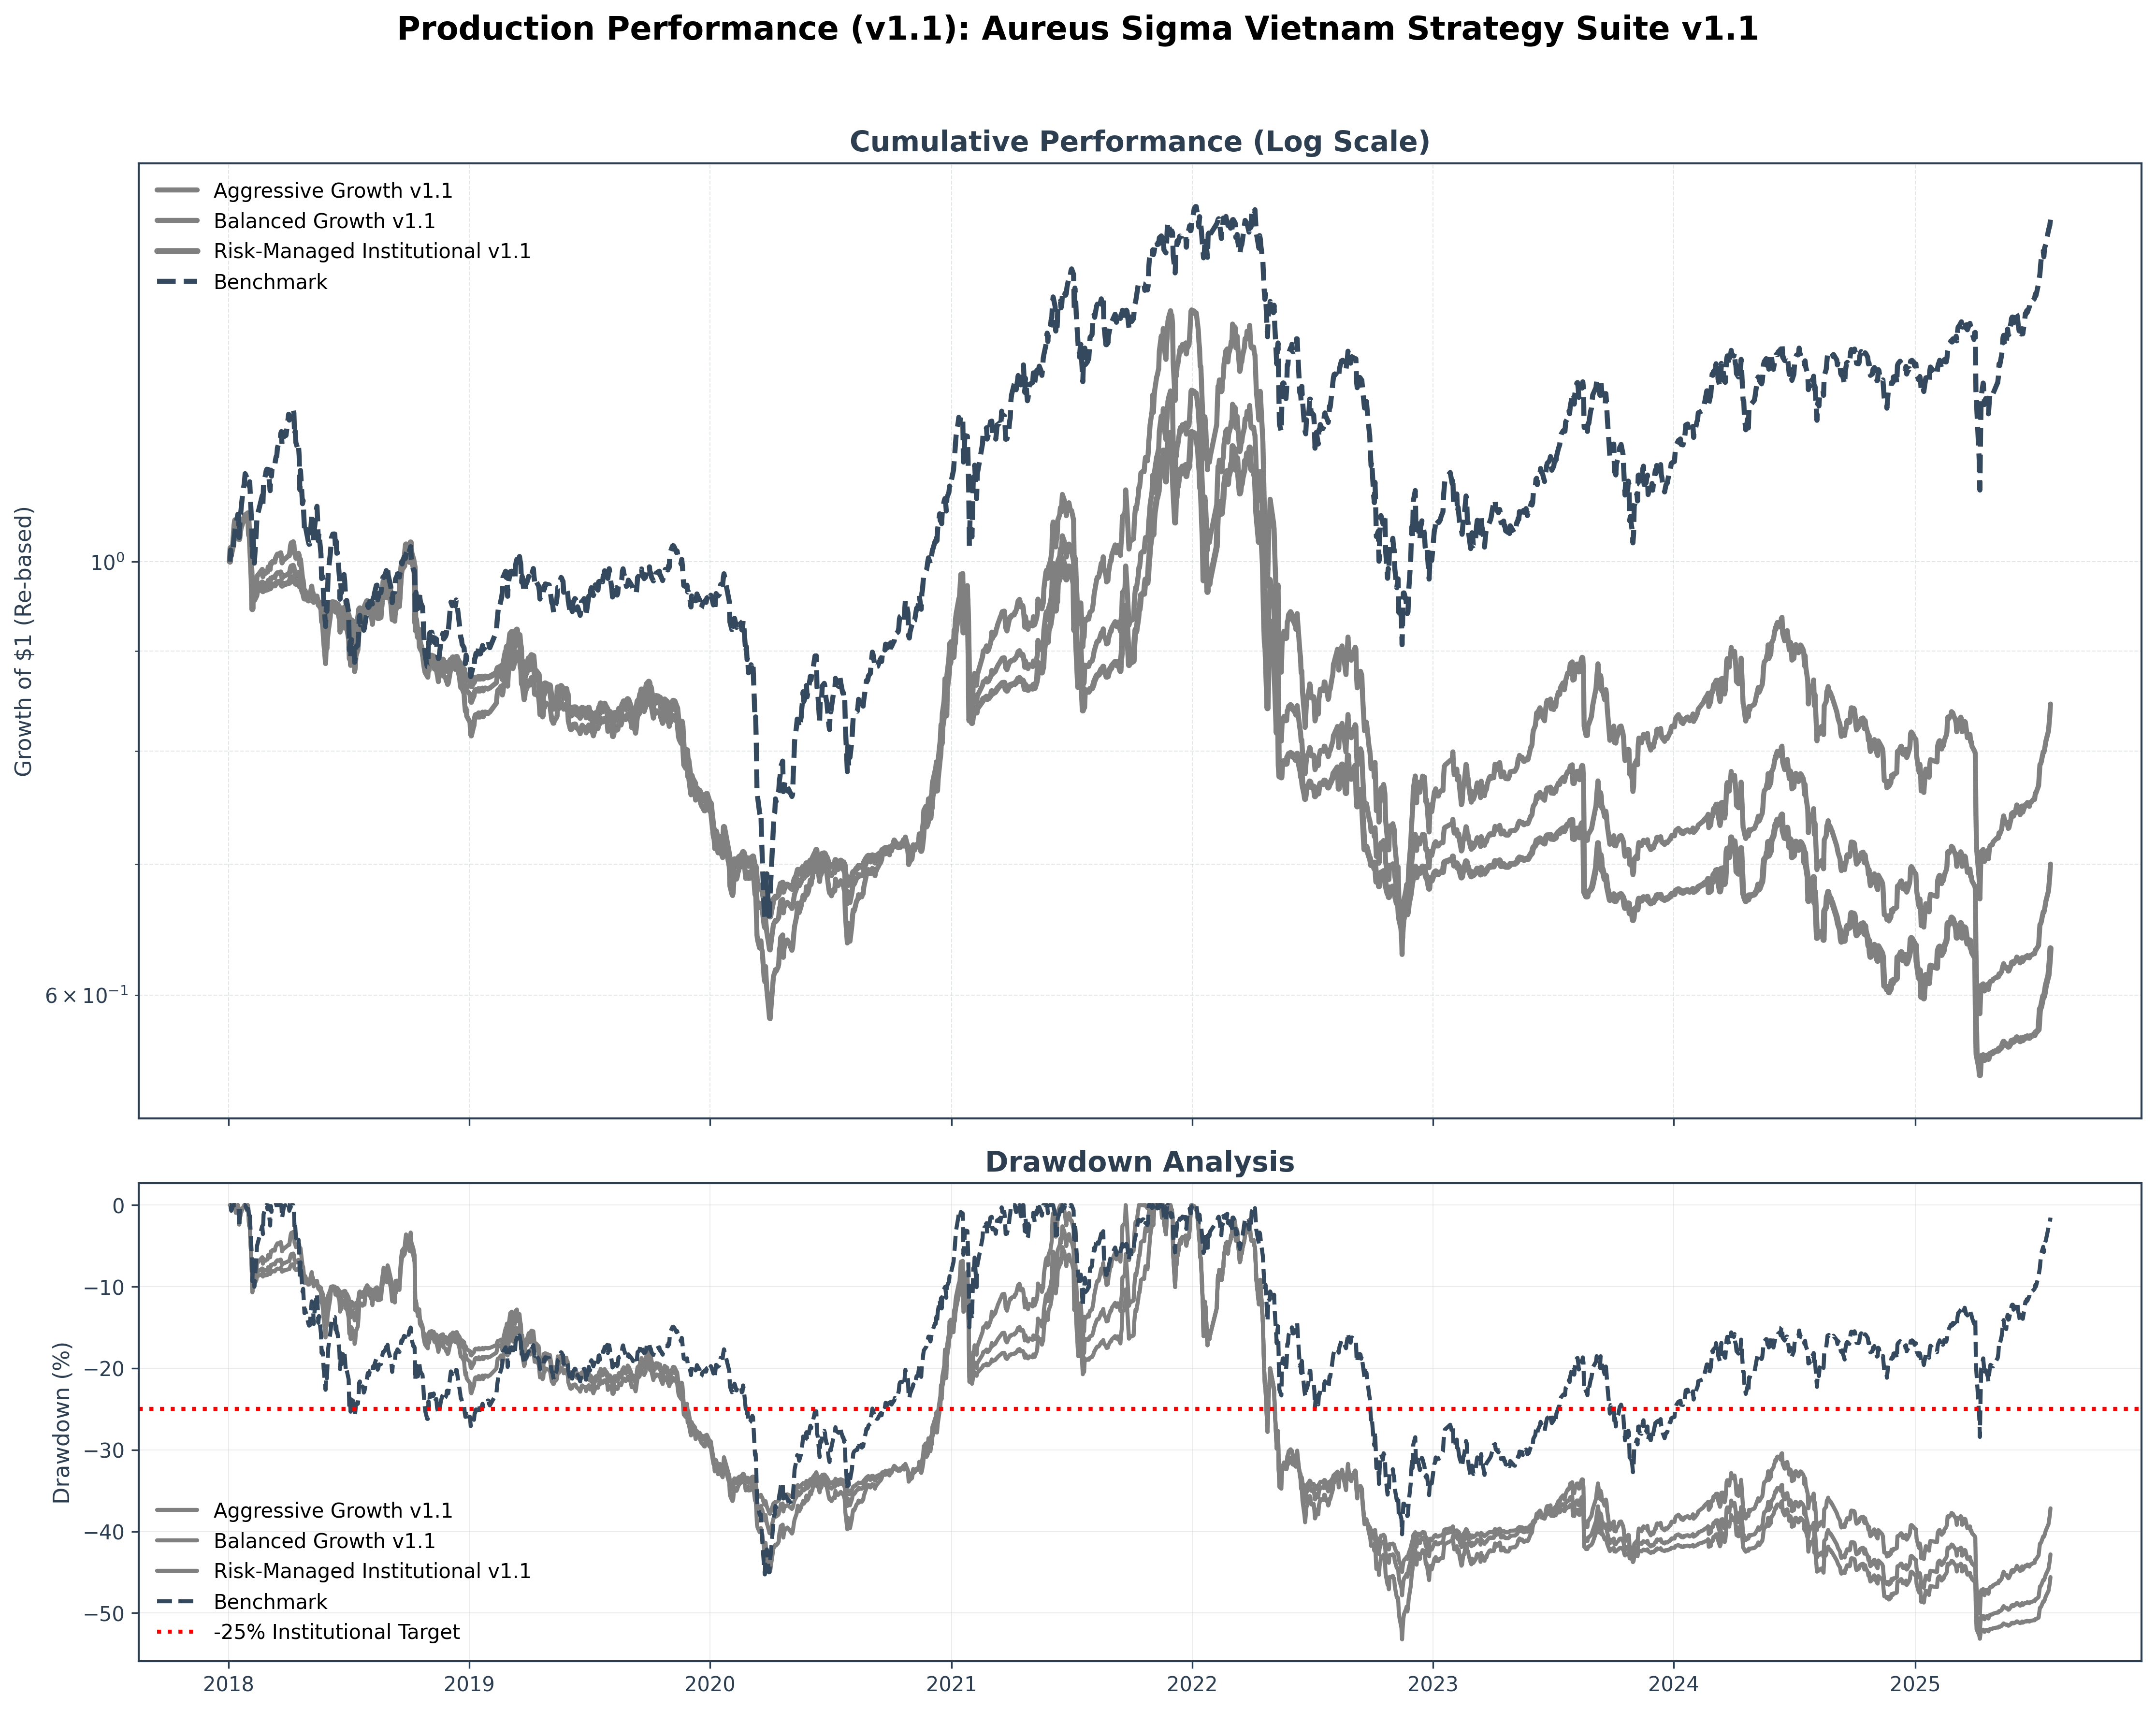


CANONICAL PERFORMANCE SUMMARY (v1.1): 2018-01-03 to 2025-07-25


,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio,Beta,Annual Alpha
Aggressive Growth v1.1,-2.11%,18.22%,-0.12,-53.23%,-0.04,0.76,-6.44%
Balanced Growth v1.1,-4.55%,16.15%,-0.28,-52.06%,-0.09,0.61,-8.01%
Risk-Managed Institutional v1.1,-5.82%,15.44%,-0.38,-53.15%,-0.11,0.53,-8.84%
Benchmark,5.69%,19.62%,0.29,-45.26%,0.13,1.00,0.00%


In [7]:
# ============================================================================
# CELL 5 (Corrected): FINAL PERFORMANCE ANALYSIS AND TEARSHEET (v1.1)
# ============================================================================

print("📊 Generating final performance analysis for the v1.1 Production Strategies...")

# --- 1. Re-base the data for fair comparison ---
strategy_columns_v1_1 = [col for col in returns_df_v1_1.columns if col != 'Benchmark']
true_inception_date_v1_1 = returns_df_v1_1[strategy_columns_v1_1].ne(0).any(axis=1).idxmax()
returns_df_rebased_v1_1 = returns_df_v1_1.loc[true_inception_date_v1_1:].copy()
print(f"   - Performance analysis re-based to true inception date: {true_inception_date_v1_1.date()}")

# --- 2. Define the Final Tearsheet Function ---
def calculate_full_performance_metrics(returns: pd.Series, benchmark: pd.Series) -> Dict[str, float]:
    common_index = returns.index.intersection(benchmark.index)
    returns, benchmark = returns.loc[common_index], benchmark.loc[common_index]
    n_years = len(returns) / 252
    annual_return = ((1 + returns).prod()) ** (1 / n_years) - 1 if n_years > 0 else 0
    annual_vol = returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_vol if annual_vol > 0 else 0
    cumulative = (1 + returns).cumprod()
    drawdown = (cumulative / cumulative.cummax() - 1)
    max_drawdown = drawdown.min()
    calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown < 0 else 0
    beta = returns.cov(benchmark) / benchmark.var() if benchmark.var() > 0 else 0
    benchmark_annual_return = ((1 + benchmark).prod()) ** (1 / n_years) - 1 if n_years > 0 else 0
    alpha = annual_return - (beta * benchmark_annual_return)
    return {
        'Annual Return': annual_return * 100, 'Annual Volatility': annual_vol * 100,
        'Sharpe Ratio': sharpe_ratio, 'Max Drawdown': max_drawdown * 100,
        'Calmar Ratio': calmar_ratio, 'Beta': beta, 'Annual Alpha': alpha * 100
    }

def create_final_tearsheet_v1_1(returns_df: pd.DataFrame, strategy_name: str):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
    fig.suptitle(f'Production Performance (v1.1): {strategy_name}', fontsize=16, fontweight='bold')
    
    cumulative_returns = (1 + returns_df).cumprod()
    cumulative_rebased = cumulative_returns.div(cumulative_returns.iloc[0])
    
    for col in cumulative_rebased.columns:
        color_key = col.split(" ")[0] # e.g., "Aggressive" from "Aggressive Growth v1.1"
        ax1.plot(cumulative_rebased.index, cumulative_rebased[col], 
                 label=col, color=STRATEGY_COLORS.get(color_key, '#808080'), 
                 linestyle=('--' if col == 'Benchmark' else '-'),
                 linewidth=(3 if "Risk-Managed" in col else 2.5))
    ax1.set_yscale('log')
    ax1.set_title('Cumulative Performance (Log Scale)', fontweight='bold')
    ax1.set_ylabel('Growth of $1 (Re-based)')
    ax1.legend(loc='upper left')
    ax1.grid(True, which="both", ls="--", alpha=0.4)

    for col in cumulative_rebased.columns:
        color_key = col.split(" ")[0]
        peak = cumulative_rebased[col].expanding(min_periods=1).max()
        drawdown = (cumulative_rebased[col] - peak) / peak
        ax2.plot(drawdown.index, drawdown * 100, label=col, color=STRATEGY_COLORS.get(color_key, '#808080'),
                 linestyle=('--' if col == 'Benchmark' else '-'))
    ax2.axhline(-25, color='red', linestyle=':', linewidth=2, label='-25% Institutional Target')
    ax2.set_title('Drawdown Analysis', fontweight='bold')
    ax2.set_ylabel('Drawdown (%)')
    ax2.legend(loc='lower left')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# --- 3. Generate Tearsheet and Summary Table ---
create_final_tearsheet_v1_1(returns_df_rebased_v1_1, "Aureus Sigma Vietnam Strategy Suite v1.1")

summary_metrics_v1_1 = {name: calculate_full_performance_metrics(returns_df_rebased_v1_1[name], returns_df_rebased_v1_1['Benchmark']) 
                        for name in returns_df_rebased_v1_1.columns}

# *** CRITICAL FIX: Define the desired order and content of the summary table explicitly ***
strategy_order = [
    "Aggressive Growth v1.1",
    "Balanced Growth v1.1",
    "Risk-Managed Institutional v1.1",
    "Benchmark"
]
summary_df_v1_1 = pd.DataFrame(summary_metrics_v1_1).T.loc[strategy_order]

print("\n" + "=" * 80)
print(f"CANONICAL PERFORMANCE SUMMARY (v1.1): {true_inception_date_v1_1.strftime('%Y-%m-%d')} to {ANALYSIS_END_DATE}")
print("=" * 80)
display(summary_df_v1_1.style.format({
    'Annual Return': '{:.2f}%', 'Annual Volatility': '{:.2f}%',
    'Sharpe Ratio': '{:.2f}', 'Max Drawdown': '{:.2f}%',
    'Calmar Ratio': '{:.2f}', 'Beta': '{:.2f}', 'Annual Alpha': '{:.2f}%'
}).background_gradient(cmap='viridis', subset=['Sharpe Ratio', 'Calmar Ratio', 'Annual Alpha']))